In [1]:
import pandas as pd
from scipy.optimize import minimize
import numpy as np

In [2]:
def get_trading_days(start_date, product_end_date):
    all_dates = pd.date_range(start=start_date, end=product_end_date)
    week_days = all_dates[all_dates.weekday < 5]
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=start_date, end=end_date)
    trading_days = week_days[~week_days.isin(holidays)]
    return trading_days 

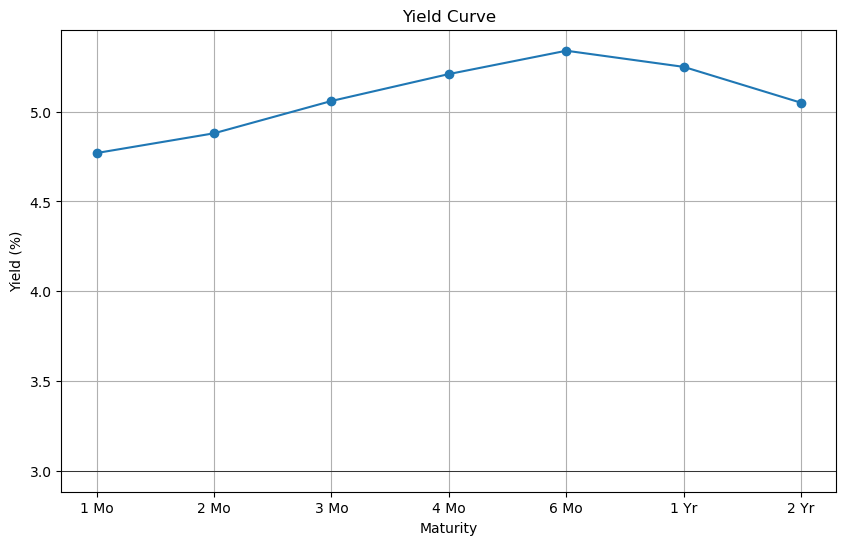

In [3]:
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

treasury = pd.read_csv('daily-treasury-rates-new.csv')
treasury
df = pd.melt(id_vars='Date',frame = treasury)

#9 Aug to 9 Nov
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Filter 1 Yr rate
one_year_rates = df[df['variable'] == '1 Yr'].sort_values(by='Date')

one_year_rates.head(5)
one_year_rates.tail(5)


one_year_rates[one_year_rates['Date']<="2023-10-09"].iloc[-1]['value']

def convert_to_days(var):
    number, unit = var.split()
    number = float(number)
    if unit == "Yr":
        return number * 365  # 1 year = 365 days
    elif unit == "Mo":
        return number * 30   # 1 month = 30 days
    else:
        return None
# Apply the function to the 'variable' column
yield_df = df
yield_df['Days'] = df['variable'].apply(convert_to_days)
#filter
yield_curve = yield_df[yield_df['Date']=='2023-03-08']
yield_curve = yield_curve[yield_curve['Days']<800]
yield_curve = yield_curve.sort_values(by="Days")
yield_curve['T']=yield_curve['Days']/365
plt.figure(figsize=(10, 6))
plt.plot(yield_curve["variable"], yield_curve["value"], marker='o')
plt.axhline(3, color='black', linewidth=0.5)  # Adding the 0 axis
plt.title('Yield Curve')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.show()

In [58]:
#!pip install nelson_siegel_svensson
import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

t = np.array(yield_curve['T'])
y = np.array(yield_curve['value']/100)

model, status = calibrate_ns_ols(t, y, tau0=0.4) #starting value of 1.0 for the optimization of tau
if status.success:
    # Print the calibrated model parameters
    print("Calibrated NSS Model Parameters:")
    print("Level (L):", model.beta0)
    print("Slope (S):", model.beta1)
    print("Curvature (C):", model.beta2)
    print("Time Constant (tau):", model.tau)
else:
    print("Calibration failed. Check your data or initial guess for tau.")
    
# Y(T) is the yield (interest rate) of a bond with maturity T.
# L is the level factor.
# S is the slope factor.
# C is the curvature factor.
# τ is the time constant that determines the speed at which the yield curve reaches its ultimate level.

Calibrated NSS Model Parameters:
Level (L): 0.04484361006797341
Slope (S): 2.576235731598618e-05
Curvature (C): 0.028565297590761447
Time Constant (tau): 0.4


In [5]:
model(3)

0.044869634857144

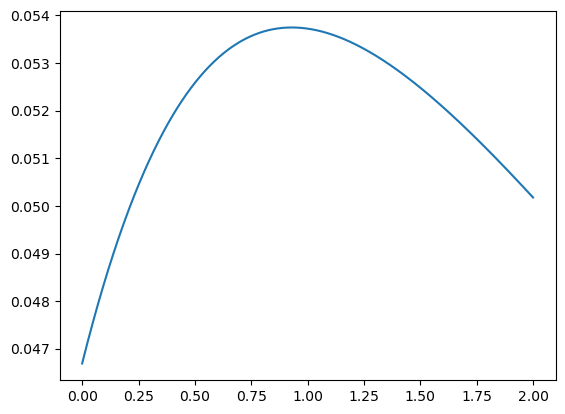

In [6]:
t = np.linspace(0, 2, 1000000)
plt.plot(t, model(t), label="A Nelson-Siegel-Svensson curve")
#plot actual yield rates here as well

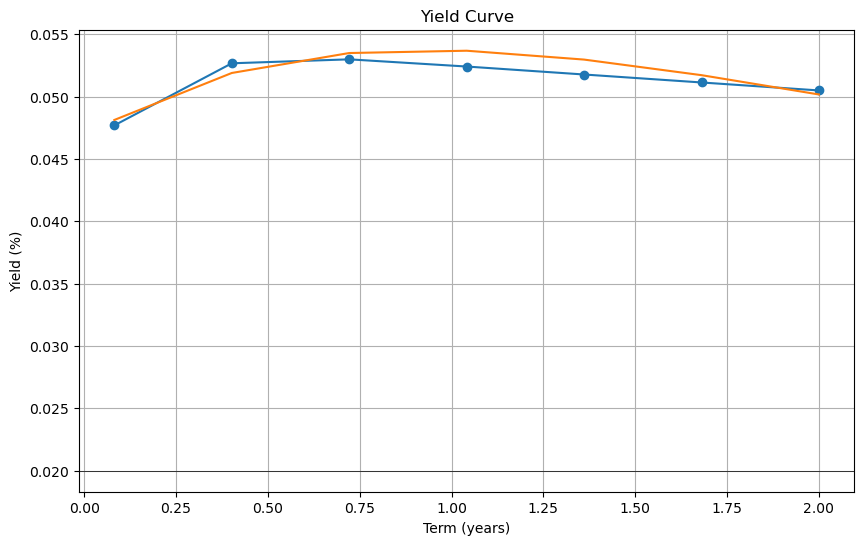

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Sample yield curve data
terms = np.array(yield_curve['T'])  # in years
yields = np.array(yield_curve['value']/100)  # in percentage

# Equidistant intervals
equidistant_terms = np.linspace(terms.min(), terms.max(), len(terms))

# Interpolating yield values for equidistant intervals
equidistant_yields = np.interp(equidistant_terms, terms, yields)

# Plotting the yield curve
plt.figure(figsize=(10, 6))
plt.plot(equidistant_terms, equidistant_yields, marker='o')
plt.plot(equidistant_terms, model(equidistant_terms), label="A Nelson-Siegel-Svensson curve")

plt.axhline(0.02, color='black', linewidth=0.5)  # Adding the 0 axis
plt.title('Yield Curve')
plt.xlabel('Term (years)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.show()

In [8]:
# !pip install yfinance
import yfinance as yf

def get_data(ticker_symbol:str, start_date:str, end_date:str):
    ticker = yf.Ticker(ticker_symbol)
    data = ticker.history(period="1d", start=start_date, end=end_date)
    return data

start_date = "2022-03-01"
end_date = "2023-11-09"

jpm = get_data("JPM", start_date, end_date)
boa = get_data("BAC", start_date, end_date)
boa.rename(columns={'Close':'boa_close'},inplace=True)
jpm.rename(columns={'Close':'jpm_close'},inplace=True)
underlying_assets = pd.concat([boa['boa_close'],jpm['jpm_close']],axis=1)
underlying_assets.tail(5)

,boa_close,jpm_close
Date,,
2023-11-02 00:00:00-04:00,27.620001,141.419998
2023-11-03 00:00:00-04:00,28.420000,143.000000
2023-11-06 00:00:00-05:00,28.330000,144.080002
2023-11-07 00:00:00-05:00,28.160000,144.009995
2023-11-08 00:00:00-05:00,27.889999,144.720001


In [59]:
import numpy as np
import pandas as pd
from scipy.linalg import cholesky
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

np.random.seed(None)


def EMSCorrectionMulti(S, r, Deltat, T):
    Nsim, num_assets, m_plus_one = S.shape
    m = m_plus_one - 1
    S_Star = np.zeros_like(S)  #this will have the same shape as S

    for asset_idx in range(num_assets):
        S_current_asset = S[:, asset_idx, :]
        S_Star_current_asset = np.zeros_like(S_current_asset)
        S_Star_current_asset[:, 0] = S_current_asset[:, 0]

        for i in range(1, m + 1):
            Z = S_current_asset[:, i - 1] * (S_current_asset[:, i] / S_current_asset[:, i - 1])
            Z_0 = np.exp(-r * (i * Deltat)) * np.mean(Z)
            S_Star_current_asset[:, i] = S_current_asset[:, 0] * Z / Z_0

        S_Star[:, asset_idx, :] = S_Star_current_asset

    return S_Star

def EMSCorrection(S,Nsim,r,Deltat,T):

    m = int(T/Deltat)
    S_Star = np.zeros((Nsim,m+1))
    S = np.array(S)
    S_Star[:,0] = S[:,0]
    Z = np.zeros((Nsim,m))

    for i in range(1,m+1):
        Z[:,i-1] = S_Star[:,i-1] * (S[:,i]/S[:,i-1])
        Z_0 = 1/(Nsim) * np.exp(-1*r*(i*Deltat)/T) * np.sum(Z[:,i-1])
        S_Star[:,i] = S_Star[:,0] * Z[:,i-1]/Z_0

    return S_Star.tolist()

def SimMultiGBMexact_av(n_sim, S0, v, Sigma, Deltat, T):
    m = int(T/Deltat)  # number of periods.
    p = len(S0)  # number of assets.
    print(f'Simulating for {len(S0)} assets, {m} trading days left to maturity')
    
    #cholesky decomposition for correlated multivariate normals
    L = np.linalg.cholesky(Sigma)
    
    #the shape is now (n_sim, p, m+1) to store n_sim paths for p assets over m+1 time points.
    S = np.zeros((n_sim, p, m+1))
    S[:, :, 0] = S0 
    
    mid = n_sim//2
    for i in range(mid):
        Z = np.dot(np.random.randn(m, p), L.T)#generate correlated random variables
        Z_anti = -Z
        for j in range(1, m+1):
            drift = (v - 0.5 * np.diag(Sigma)) * Deltat
            diffusion1 = np.sqrt(Deltat) * Z[j-1, :]
            diffusion2 = np.sqrt(Deltat) * Z_anti[j-1, :]
            S[i, :, j] = S[i, :, j-1] * np.exp(drift + diffusion1)
            S[i+mid, :, j] = S[i+mid, :, j-1] * np.exp(drift + diffusion2)
    return S


def SimMultiGBMexact(n_sim, S0, v, Sigma, Deltat, T):
    m = int(T/Deltat)  # number of periods.
    p = len(S0)  # number of assets.
    print(f'Simulating for {len(S0)} assets, {m} trading days left to maturity')
    
    #cholesky decomposition for correlated multivariate normals
    L = np.linalg.cholesky(Sigma)
    
    #the shape is now (n_sim, p, m+1) to store n_sim paths for p assets over m+1 time points.
    S = np.zeros((n_sim, p, m+1))
    S[:, :, 0] = S0 
    
    for i in range(n_sim):
        Z = np.dot(np.random.randn(m, p), L.T)#generate correlated random variables
        for j in range(1, m+1):
            drift = (v - 0.5 * np.diag(Sigma)) * Deltat
            diffusion = np.sqrt(Deltat) * Z[j-1, :]
            S[i, :, j] = S[i, :, j-1] * np.exp(drift + diffusion)
    
    return S

def compute_payoff(simulated_prices, initial_levels, barrier, T, conversion_rates, denomination=1000.0):
    #determine coupon based on Time to maturiry
#     coupon = 0.1025*T # before 1st quarter payment
    if 0.75 < T <= 1: # before 2nd quarter payment
        coupon = 0.1025 
    elif 0.5 < T <= 0.75: # before 3rd quarter payment
        coupon = 0.076875
    elif 0.25 < T <= 0.5:  # before 4th quarter payment
        coupon = 0.05125
    else:  # before last quarter payment
        coupon = 0.025625
    print(coupon)
    n_sim, p, _ = simulated_prices.shape
    results = []
    
    for sim in range(n_sim):
        if all(price >= initial_levels[i] for i, price in enumerate(simulated_prices[sim][:, -1])):
            results.append(denomination + coupon * denomination) # barrier reversed if breached
        else:
            if any(price < barrier[i] for i in range(p) for price in simulated_prices[sim][i]):
                # Get worst performing share and respective conversion rate
                worst_performance, k = 1000 , -1
                for j in range(len(simulated_prices[sim])):
                    if simulated_prices[sim][j][-1]*conversion_rates[j] < worst_performance:
                        worst_performance = simulated_prices[sim][j][-1]*conversion_rates[j]
                        k = j
#                 print(worst_performance + coupon * denomination)
                results.append(worst_performance + coupon * denomination) # barrier breached
                
            else:
                results.append(denomination + coupon* denomination) #  barrier not breached
    return results


def fake_compute_payoff(simulated_prices, initial_levels, barrier, T, conversion_rates, denomination=1000.0):
    #determine coupon based on Time to maturiry
    coupon = 0.025625 # before 1st quarter payment
    if 0.75 < T <= 1: # before 2nd quarter payment
        coupon = 0.05125
    elif 0.5 < T <= 0.75: # before 3rd quarter payment
        coupon = 0.076875
    elif 0.25 < T <= 0.5:  # before 4th quarter payment
        coupon = 0.1025
    else:  # before last quarter payment
        coupon = 0.128125
    
    n_sim, p, _ = simulated_prices.shape
    results = []
    
    for sim in range(n_sim):
        if all(price >= initial_levels[i] for i, price in enumerate(simulated_prices[sim][:, -1])):
            results.append(denomination + coupon * denomination) # barrier reversed if breached
        else:
            if any(price < barrier[i] for i in range(p) for price in simulated_prices[sim][i]):
                # Get worst performing share and respective conversion rate
                worst_performance, k = 1000 , -1
                for j in range(len(simulated_prices[sim])):
                    if simulated_prices[sim][j][-1]*conversion_rates[j] < worst_performance:
                        worst_performance = simulated_prices[sim][j][-1]*conversion_rates[j]
                        k = j
#                 print(worst_performance + coupon * denomination)
                results.append(worst_performance + coupon * denomination) # barrier breached
                
            else:
                results.append(denomination + coupon* denomination) #  barrier not breached
    
    return results



initial_levels = np.array([34.14, 142.55])
barrier = initial_levels *0.55
conversion_rates = np.array([29.2912, 7.0151])
print('Initial prices',initial_levels)
print('Barrier prices',barrier)


np.random.seed(None)

def Sim_GBM_exact(n_sim, S0, mu, sigma, delta_t,T,risk_neutral=True,r=0.02):
    """
    Simulate stock prices using the Geometric Brownian Motion (GBM) model with exact discretization.
    """
    v = mu - sigma**2/2 if not risk_neutral else r - sigma**2/2
    m = int(T/delta_t)
    S = np.zeros((n_sim, m+1))
    S[:, 0] = S0
    for i in range(n_sim):
        Z = np.random.normal(0, 1, m)
        for j in range(1, m+1):
            S[i, j] = S[i, j-1] * np.exp(v * delta_t + sigma * np.sqrt(delta_t) * Z[j-1])
    return S


import numpy as np
from sklearn.linear_model import LinearRegression

def estimate_CIR_params(r_t: np.ndarray):
    """
    Estimate CIR params from OLS regression.
    - r_t is 1D array.
    """
    # define regression specification
    r_sqrt = np.sqrt(r_t[:-1])
    y = np.diff(r_t) / r_sqrt
    x1 = 1.0 / r_sqrt
    x2 = r_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return (a, b, c)

def simCIR(params, r_0, n_sim, Deltat, T):
    '''
    Function to simulate GBM 
    -------------------------
    INPUTS
    - params :  a, b, c (parameters for CIR model)
    - r_0 : initial value 
        
    '''
    a,b,c = params[0], params[1], params[2]
    m = int(T/Deltat)  # number of periods
    R = np.zeros((n_sim, m+1))
    R[:, 0] = r_0
    for i in range(n_sim):
        Z = np.random.normal(0.0, 1.0, m)
        for j in range(1, m+1):
            drift = a * (b - R[i, j-1]) * Deltat
            diffusion = c * np.sqrt(R[i, j-1]) * Z[j-1] * np.sqrt(Deltat) 
            R[i, j] = R[i,j-1] + drift + diffusion

    return R[:, -1].mean()


params = estimate_CIR_params(np.array(yield_df.loc[(yield_df['variable']=='1 Mo') & (yield_df['Date']<="2023-08-08")]['value'])/100)
print(params)

Initial prices [ 34.14 142.55]
Barrier prices [18.777  78.4025]
(0.04281815398010842, 0.050845718301161795, 0.007084357958851824)


In [70]:
# !pip install mgarch
import mgarch
from sklearn.covariance import LedoitWolf


def get_derivative_prices(df, start_date, end_date, product_end_date,sliding_window:int=252,n_sim:int = 10000):
    df.index = df.index.tz_localize(None)
    simulation_dates = df[(df.index >= start_date) & (df.index <= end_date)].index.tolist()
    derivative_prices = np.full(len(simulation_dates), np.nan)
    derivative_prices_ems = np.full(len(simulation_dates), np.nan)
    derivative_prices_r2 = np.full(len(simulation_dates), np.nan)
    derivative_prices_call = np.full(len(simulation_dates), np.nan)
    derivative_prices_r3 = np.full(len(simulation_dates), np.nan)
    derivative_prices_av = np.full(len(simulation_dates), np.nan)
    derivative_prices_garch = np.full(len(simulation_dates), np.nan)
    derivative_prices_sep = np.full(len(simulation_dates), np.nan)
    
    variance_prices = np.full(len(simulation_dates), np.nan)

    variance_prices_av = np.full(len(simulation_dates), np.nan)
    
    variance_prices_ems = np.full(len(simulation_dates), np.nan)


    call_mat = np.full((len(simulation_dates),n_sim),np.nan)

    dt = 1/252
    for idx, date in enumerate(simulation_dates):
        ir_df = yield_df[yield_df['Date']==date]
        ir_df = ir_df[ir_df['Days']<800] #remove all 2 days one
        ir_df = ir_df.sort_values(by="Days")
        ir_df['T']=ir_df['Days']/365
        t = np.array(ir_df['T'])
        y = np.array(ir_df['value']/100)

        model, status = calibrate_ns_ols(t, y, tau0=1)  #starting value of 1.0 for the optimization of tau
        assert status.success
        
        r1 = one_year_rates[one_year_rates['Date']<=date].iloc[-1]['value']/100
        r1_month = yield_df.loc[(yield_df['variable']=='1 Mo') & (yield_df['Date']<=date)].iloc[-1]['value']/100

        historical_data = df[df.index < date].tail(sliding_window+1)
        trading_days = len(get_trading_days(date,product_end_date))        
        T = trading_days * dt #time to maturity
#         if T == 1:
#             print(idx)
#         if T == 0.75:
#             print(idx)
        r2 = model(T)
        params = estimate_CIR_params(np.array(yield_df.loc[(yield_df['variable']=='1 Mo') & (yield_df['Date']<=date)]['value'])/100)
        r3 = simCIR(params,r1_month, n_sim, dt, T)
        
#         print(r1,r2,r3)
        underlying_prices = historical_data.iloc[:, 0:2].values
        log_prices = np.log(underlying_prices)
        log_returns = np.diff(log_prices, axis=0)
        v = np.mean(log_returns,axis=0)/dt # this one will use risk free rate instead of v
#         print(v)
        sigma = np.cov(log_returns,rowvar=False)/dt
        
        lw = LedoitWolf(assume_centered=True)

        lw.fit(log_returns)
         
        shrunk_sigma = lw.covariance_/dt
        print(shrunk_sigma,sigma)
        sigma = shrunk_sigma
    
        #vol = mgarch.mgarch()
        #vol.fit(log_returns)
        
        #sigma_garch = vol.predict(5)['cov']/dt
        
         #print(sigma_garch,sigma)
        
        S0 = underlying_prices[-1, :] #here should we use ydays price or todays price
    
        def post_processing(simulated_prices,T,r,ems=True):
            if ems:
                simulated_prices[:,0,:] = EMSCorrection(simulated_prices[:,0,:],n_sim,r,dt,T)
                simulated_prices[:,1,:] = EMSCorrection(simulated_prices[:,1,:],n_sim,r,dt,T)
            payoffs = compute_payoff(simulated_prices, initial_levels, barrier, T, conversion_rates) # Added conversion rate

            return payoffs
        
        #Baseline
        simulated_prices = SimMultiGBMexact(n_sim,S0,r1,sigma, dt, T)
        payoffs = post_processing(simulated_prices,T,r1,ems=False)
        derivative_prices[idx] = np.mean(payoffs)*np.exp(-r1*T)#monte carlo, can add other techniques here
        variance_prices[idx] = np.var(payoffs)
        
        #Baseline
#         call_mat[idx,:] = payoffs
#         if idx == 75:
#             X = call_mat[12]
#             Y = call_mat[75]

#             X2=X**2
#             X = np.reshape(X, (-1,1))
#             X = np.insert(X, 1, X2, axis=1)
#             LR = LinearRegression().fit(X, Y)
#             F = LR.predict(X)
            
#             for i in range(len(F)):
#                 if F[i] > 1076.875: payoffs[i] = 1076.875
            
#             shouldRedeem = np.where(1076.875< F, 1, 0)
#             print(np.sum(shouldRedeem))
#         derivative_prices_call[idx] = np.mean(payoffs)*np.exp(-r1*T)#monte carlo, can add other techniques here
    
        payoffs = post_processing(simulated_prices,T,r1,ems=True)
        derivative_prices_ems[idx] = np.mean(payoffs)*np.exp(-r1*T)#monte carlo, can add other techniques here
        variance_prices_ems[idx] = np.var(payoffs)

        #Using interpolated r 
        simulated_prices = SimMultiGBMexact(n_sim,S0,r2,sigma, dt, T)
        payoffs = post_processing(simulated_prices,T,r2,ems=False)
        derivative_prices_r2[idx] = np.mean(payoffs)*np.exp(-r2*T)#monte carlo, can add other techniques here
        
    
    
        #Using interpolated r stochastic
        simulated_prices = SimMultiGBMexact(n_sim,S0,r3,sigma, dt, T)
        payoffs = post_processing(simulated_prices,T,r3,ems=False)
        derivative_prices_r3[idx] = np.mean(payoffs)*np.exp(-r3*T)#monte carlo, can add other techniques here
        
        #Using variance reduction techniques
        simulated_prices = SimMultiGBMexact_av(n_sim,S0,r3,sigma, dt, T)
        payoffs = post_processing(simulated_prices,T,r3,ems=False)
        derivative_prices_av[idx] = np.mean(payoffs)*np.exp(-r3*T)#monte carlo, can add other techniques here
        
        variance_prices_av[idx] = np.var(payoffs)
        log_returns_boa = log_returns[:, 0]
        log_returns_jp = log_returns[:, 1]
        
        sigma_boa = np.std(log_returns_boa)/np.sqrt(dt)
        sigma_jp = np.std(log_returns_jp)/np.sqrt(dt)
        
        boa_prices = Sim_GBM_exact(n_sim, S0[0], r3, sigma_boa,dt, T)
        jp_prices = Sim_GBM_exact(n_sim, S0[1], r3, sigma_jp, dt, T)
        
        combined_prices = np.zeros((n_sim, 2, boa_prices.shape[1]))
        for i in range(n_sim):
            combined_prices[i, 0] = boa_prices[i]
            combined_prices[i, 1] = jp_prices[i]
            
        payoffs =  post_processing(combined_prices,T,r3,ems=False)
        derivative_prices_sep[idx] = np.mean(payoffs)*np.exp(-r3*T)
        
        #Using Garch model
#         simulated_prices = SimMultiGBMexact_av(n_sim,S0,r3,sigma_garch, dt, T)
#         payoffs = post_processing(simulated_prices,T,r3,ems=True)
#         derivative_prices_garch[idx] = np.mean(payoffs)*np.exp(-r3*T)#monte carlo, can add other techniques here
        
        
    derivative_prices_df = pd.DataFrame({
        'Dates': simulation_dates,
        'derivative_prices': derivative_prices,
        'derivative_prices_ems': derivative_prices_ems,
        'derivative_prices_r2': derivative_prices_r2,
        'derivative_prices_r3': derivative_prices_r3,
        'derivative_prices_av': derivative_prices_av,
        'derivative_prices_sep': derivative_prices_sep,
        'derivative_prices_call': derivative_prices_call,
#         'derivative_prices_garch': derivative_prices_garch,
        'variance_prices_av': variance_prices_av,
        'variance_prices': variance_prices,
        'variance_prices_ems': variance_prices_ems
        
        })
    print(call_mat)
    return derivative_prices_df, call_mat


df, call_mat= get_derivative_prices(underlying_assets,'2023-08-08','2023-11-08','2024-06-10',300,10000)
actual_price = pd.read_csv('prices-aug8-nov8.csv')
actual_price["dates"]=pd.to_datetime(actual_price['dates'])
df = pd.merge(actual_price,df,left_on="dates",right_on="Dates",how="left")
df.drop(columns=["Unnamed: 0"],inplace=True)

[[0.08429002 0.06103899]
 [0.06103899 0.06762068]] [[0.08481181 0.06320597]
 [0.06320597 0.06741356]]
Simulating for 2 assets, 218 trading days left to maturity
Simulating for 2 assets, 218 trading days left to maturity
Simulating for 2 assets, 218 trading days left to maturity
Simulating for 2 assets, 218 trading days left to maturity
[[0.08415994 0.06079401]
 [0.06079401 0.06740377]] [[0.08465957 0.06298821]
 [0.06298821 0.06722292]]
Simulating for 2 assets, 217 trading days left to maturity
Simulating for 2 assets, 217 trading days left to maturity
Simulating for 2 assets, 217 trading days left to maturity
Simulating for 2 assets, 217 trading days left to maturity
[[0.0842296  0.06083335]
 [0.06083335 0.06739214]] [[0.08471272 0.06302879]
 [0.06302879 0.06724316]]
Simulating for 2 assets, 216 trading days left to maturity
Simulating for 2 assets, 216 trading days left to maturity
Simulating for 2 assets, 216 trading days left to maturity
Simulating for 2 assets, 216 trading days lef

Simulating for 2 assets, 194 trading days left to maturity
Simulating for 2 assets, 194 trading days left to maturity
Simulating for 2 assets, 194 trading days left to maturity
[[0.08067076 0.05667588]
 [0.05667588 0.06251297]] [[0.08124591 0.05885742]
 [0.05885742 0.06217483]]
Simulating for 2 assets, 193 trading days left to maturity
Simulating for 2 assets, 193 trading days left to maturity
Simulating for 2 assets, 193 trading days left to maturity
Simulating for 2 assets, 193 trading days left to maturity
[[0.08059227 0.05664005]
 [0.05664005 0.06250034]] [[0.08116841 0.05881821]
 [0.05881821 0.06215576]]
Simulating for 2 assets, 192 trading days left to maturity
Simulating for 2 assets, 192 trading days left to maturity
Simulating for 2 assets, 192 trading days left to maturity
Simulating for 2 assets, 192 trading days left to maturity
[[0.0806407  0.05677588]
 [0.05677588 0.06276975]] [[0.08121556 0.0589366 ]
 [0.0589366  0.06238696]]
Simulating for 2 assets, 191 trading days lef

Simulating for 2 assets, 171 trading days left to maturity
[[0.07551716 0.05155127]
 [0.05155127 0.05818374]] [[0.07597845 0.05375283]
 [0.05375283 0.05783827]]
Simulating for 2 assets, 170 trading days left to maturity
Simulating for 2 assets, 170 trading days left to maturity
Simulating for 2 assets, 170 trading days left to maturity
Simulating for 2 assets, 170 trading days left to maturity
[[0.07579211 0.05136062]
 [0.05136062 0.05807064]] [[0.07630009 0.05354179]
 [0.05354179 0.05769932]]
Simulating for 2 assets, 169 trading days left to maturity
Simulating for 2 assets, 169 trading days left to maturity
Simulating for 2 assets, 169 trading days left to maturity
Simulating for 2 assets, 169 trading days left to maturity
[[0.07576358 0.05136914]
 [0.05136914 0.05810433]] [[0.07624738 0.05356   ]
 [0.05356    0.05776612]]
Simulating for 2 assets, 168 trading days left to maturity
Simulating for 2 assets, 168 trading days left to maturity
Simulating for 2 assets, 168 trading days lef

In [71]:
df

,dates,price,Dates,derivative_prices,derivative_prices_ems,derivative_prices_r2,derivative_prices_r3,derivative_prices_av,derivative_prices_sep,derivative_prices_call,variance_prices_av,variance_prices,variance_prices_ems
0,2023-08-08,96.60,2023-08-08,1019.906103,1021.208086,1018.670689,1019.110851,1018.571886,1010.116763,NaN,8991.185963,9062.821859,8466.362461
1,2023-08-09,96.80,2023-08-09,1014.899730,1016.400252,1016.873200,1015.581157,1015.983239,1007.907247,NaN,10093.332132,11215.899886,10546.182355
2,2023-08-10,96.70,2023-08-10,1014.172168,1015.528005,1013.105089,1011.602250,1010.877539,1002.170180,NaN,12115.482615,11448.549409,10835.755091
3,2023-08-11,96.93,2023-08-11,1013.576088,1015.451194,1014.030999,1013.395638,1013.395835,1004.665012,NaN,10952.454365,11519.193384,10676.082487
4,2023-08-14,96.67,2023-08-14,1016.278117,1017.997322,1016.735668,1014.802874,1015.341405,1008.753302,NaN,9929.694392,10280.185452,9548.182807
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2023-11-02,95.51,2023-11-02,986.599759,992.356432,983.920535,985.233596,984.217863,975.400638,NaN,18834.332028,18156.953984,15763.563079
63,2023-11-03,97.06,2023-11-03,999.502557,1004.812880,997.957789,998.693112,998.084421,991.992150,NaN,13203.952296,13227.310385,10984.276056
64,2023-11-06,96.68,2023-11-06,1005.515248,1009.669301,1004.760498,1006.126522,1005.344954,1000.850377,NaN,10064.990723,10579.298684,8735.684450
65,2023-11-07,96.85,2023-11-07,1006.926641,1010.602882,1007.772180,1004.827773,1004.630672,999.085669,NaN,10329.439413,9885.583183,8256.943678


In [84]:
df.describe()

,dates,price,Dates,derivative_prices,derivative_prices_ems,derivative_prices_r2,derivative_prices_r3,derivative_prices_av,derivative_prices_sep,derivative_prices_call,variance_prices_av,variance_prices,variance_prices_ems
count,67,67.000000,66,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,0.0,66.000000,66.000000,66.000000
mean,2023-09-22 19:20:35.820895488,95.201194,2023-09-23 02:10:54.545454592,994.622016,998.633578,994.482742,993.902793,994.141881,984.364103,NaN,16725.746422,16880.877770,15229.408123
min,2023-08-08 00:00:00,91.600000,2023-08-08 00:00:00,960.141222,968.289800,956.828805,955.868759,961.379785,948.312123,NaN,8991.185963,9062.821859,8176.767937
25%,2023-08-30 12:00:00,94.445000,2023-08-30 06:00:00,988.222782,993.801235,990.006633,988.278391,989.518938,977.982942,NaN,14190.258646,13762.471911,12512.502374
50%,2023-09-22 00:00:00,95.490000,2023-09-23 12:00:00,996.882830,1000.623153,996.268948,996.549410,995.722927,986.925080,NaN,16391.219277,16620.593477,15344.049776
75%,2023-10-16 12:00:00,96.415000,2023-10-16 18:00:00,1002.974914,1005.562062,1002.483565,1002.114455,1002.545724,993.917405,NaN,18647.559841,18707.424375,16651.848496
max,2023-11-08 00:00:00,97.190000,2023-11-08 00:00:00,1019.906103,1021.208086,1018.670689,1019.110851,1018.571886,1010.116763,NaN,27339.427931,27557.976326,24649.622990
std,NaN,1.455644,NaN,13.160841,11.584789,13.176736,13.252495,12.677962,14.342107,NaN,4178.310340,4374.484381,3912.144940


In [75]:
df.to_csv("experiment_shrunk.csv",index=False)

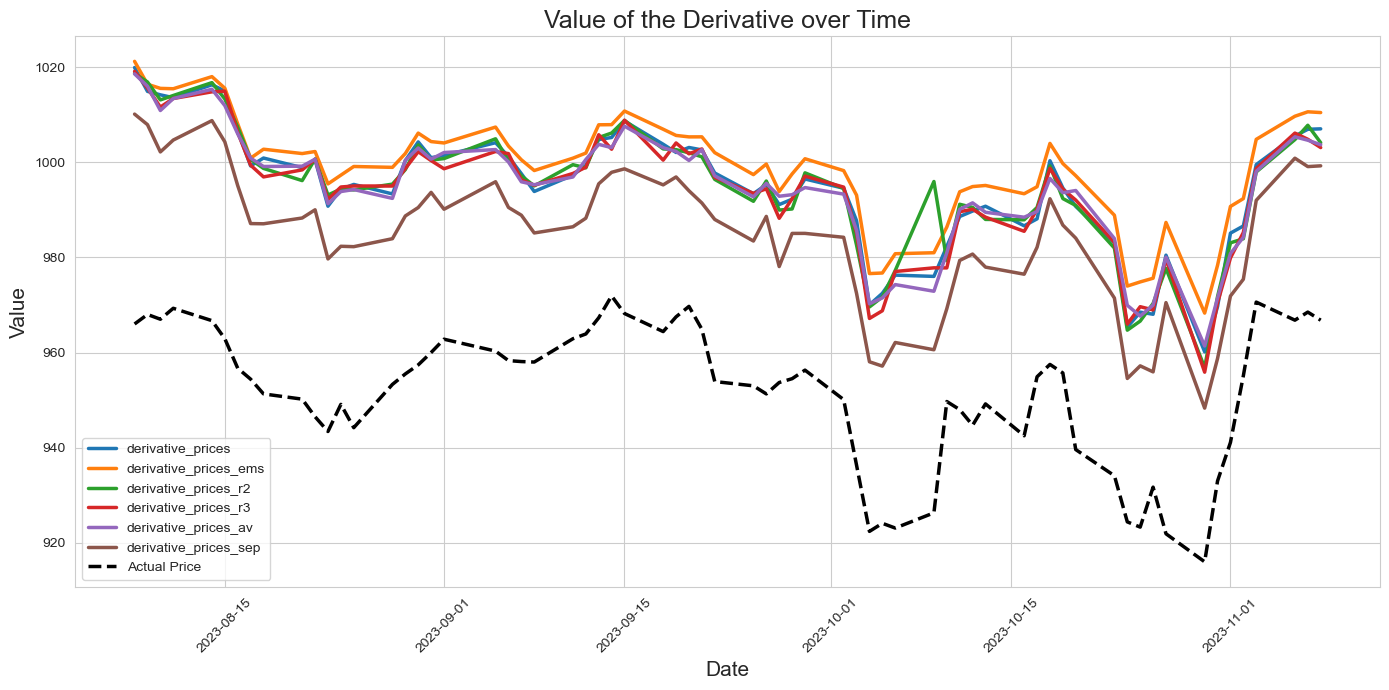

In [78]:
import seaborn as sns
def plot_derivative(df):
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    # Use 'Dates' column for x-axis
    date_col = pd.to_datetime(df['Dates'])

    # Plot each 'derivative_prices_xxx' column
    price_columns = ['derivative_prices', 'derivative_prices_ems', 'derivative_prices_r2','derivative_prices_r3', 'derivative_prices_av','derivative_prices_sep']
#     price_columns = ['derivative_prices_r3','derivative_prices']

    for column in price_columns:
        plt.plot(date_col, df[column], lw=2.5, label=column)

    # Plot actual price for comparison, multiplied by a factor for scale adjustment if needed
    plt.plot(date_col, df['price']*10, color='black', lw=2.5, linestyle='--', label="Actual Price")

    plt.title("Value of the Derivative over Time", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Value", fontsize=15)
    plt.legend(loc="best")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()

    plt.show()

# Assuming df is your DataFrame
plot_derivative(df.drop(columns = ['derivative_prices_call']).dropna())

In [79]:
import numpy as np

# Assuming your DataFrame is named df and has the following columns
price_columns = ['derivative_prices', 'derivative_prices_ems', 'derivative_prices_r2','derivative_prices_r3', 'derivative_prices_av','derivative_prices_sep']

# RMSE calculation for each time series
for column in price_columns:
    differences = df[column] - (df['price']*10)
    squared_differences = differences ** 2
    mean_squared_differences = np.mean(squared_differences)
    rmse = np.sqrt(mean_squared_differences)
    print(f"RMSE for {column}: {rmse}")

RMSE for derivative_prices: 43.25745735579591
RMSE for derivative_prices_ems: 47.2312955498916
RMSE for derivative_prices_r2: 43.23574024441046
RMSE for derivative_prices_r3: 42.57526513686682
RMSE for derivative_prices_av: 42.79755890198972
RMSE for derivative_prices_sep: 33.06644074346155


In [24]:
df.to_csv('experiment2.csv',index=False)

0.7696211922313706 
0.701925666731835 _ems
0.7115537234618039 _r2
0.7583724299558184 _r3
0.7435679679641956 _av
0.830438186233414 _sep
nan _call
-0.00636967505711894 v
-0.006096277980652154 
-0.006735402152333592 ms


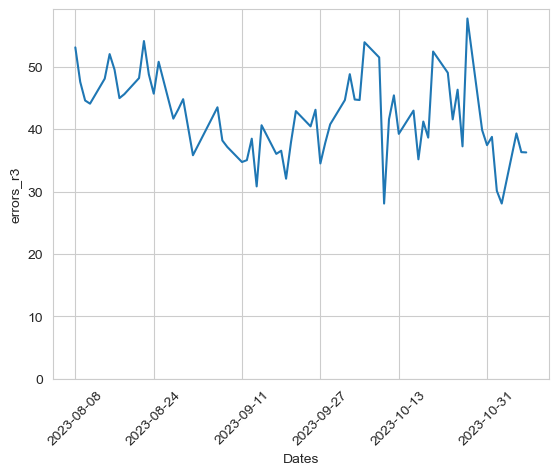

In [80]:
def error_against_time(input_df,name):
    df = input_df.copy()
    for col in df.columns[3:]:
        errors = abs(df['price']*10 - df[col])
        variance_errors = np.var(errors)
        df['errors'+col[17:]] = errors
        total= np.var(df[col])
        print(1-variance_errors/total,col[17:])
        
    
    sns.lineplot(data = df, x = 'Dates', y = name)
    x = df['Dates']
    plt.ylim(0)
    plt.xticks(x[::12], rotation = 45)
    plt.show()
error_against_time(df,'errors_r3')

In [83]:
from dtaidistance import dtw
import numpy as np

# Assuming your DataFrame is named df and has the following columns
price_columns = ['derivative_prices', 'derivative_prices_ems', 'derivative_prices_r2','derivative_prices_r3', 'derivative_prices_av','derivative_prices_sep']
actual_price_series = df['price'] * 10  # Adjusting the actual price
# DTW distance calculation for each time series
for column in price_columns:
    derivative_series = df[column]
    dtw_distance = dtw.distance(derivative_series.dropna().tolist(), actual_price_series.dropna().tolist())
    print(f"DTW distance for {column}: {dtw_distance}")

DTW distance for derivative_prices: 269.021750667487
DTW distance for derivative_prices_ems: 313.3531995143818
DTW distance for derivative_prices_r2: 261.5715821161753
DTW distance for derivative_prices_r3: 256.676909915726
DTW distance for derivative_prices_av: 267.5072719466457
DTW distance for derivative_prices_sep: 186.56947788215462


In [559]:
import itertools
import operator

def judgePoint24(cards):
    # Define basic arithmetic operations
    ops = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul,
        '/': operator.truediv
    }

    # Function to generate all possible results from two numbers and corresponding equations
    def generate(a, b):
        results = []
        for op in ops:
            if op == '/' and b == 0:
                continue
            results.append((ops[op](a[0], b[0]), f"({a[1]} {op} {b[1]})"))
        return results

    # Depth-First Search function to explore all combinations
    def dfs(nums):
        if len(nums) == 1:
            return abs(nums[0][0] - 24) < 0.001, nums[0][1]

        for i in range(len(nums)):
            for j in range(len(nums)):
                if i != j:
                    next_nums = [nums[k] for k in range(len(nums)) if k != i and k != j]
                    for result in generate(nums[i], nums[j]):
                        next_nums.append(result)
                        found, equation = dfs(next_nums)
                        if found:
                            return True, equation
                        next_nums.pop()
        return False, ""

    # Generate all permutations of the numbers
    for nums_perm in itertools.permutations(cards):
        # Convert numbers to (value, string) tuples
        nums = [(num, str(num)) for num in nums_perm]
        found, equation = dfs(nums)
        if found:
            return True, equation

    return False, ""

# Example usage
cards = [4, 1, 8, 7]
result, equation = judgePoint24(cards)
print("Result:", result, "Equation:", equation)


Result: True Equation: (8 * (7 - (4 * 1)))


In [433]:
actual_price_series_cleaned

array([966. , 968. , 967. , 969.3, 966.7, 962.9, 956.7, 954.4, 951.3,
       950.2, 946.5, 943.4, 949.1, 944.2, 953.3, 955.5, 957.4, 960. ,
       962.8, 964.6, 960.3, 958.3, 958.1, 958. , 962.9, 963.9, 967.3,
       971.9, 968.2, 964.4, 967.5, 969.7, 964.9, 953.9, 953. , 951.3,
       953.7, 954.5, 956.3, 950.1, 936.3, 922.4, 924.1, 923.1, 926.3,
       949.7, 948. , 944.7, 949.2, 942.5, 954.9, 957.5, 955.7, 939.6,
       934.1, 924.4, 923.3, 931.7, 921.9, 916. , 933. , 941.1, 955.1,
       970.6, 966.8, 968.5, 966.8])

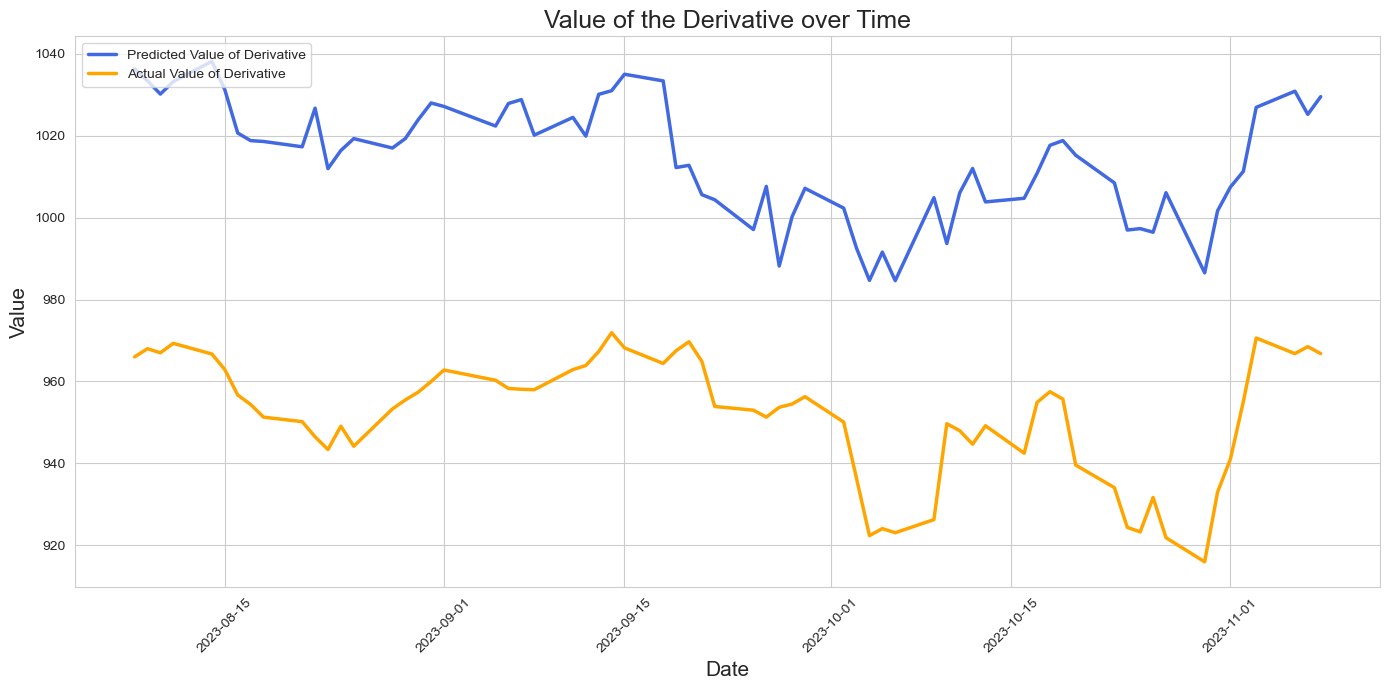

In [361]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for better styling

def plot_derivative(df):
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(df['Dates'], df['der'], color='royalblue', lw=2.5, label="Predicted Value of Derivative")
    plt.plot(df['Dates'], df['price']*10, color='orange', lw=2.5, label="Actual Value of Derivative")
    
    plt.title("Value of the Derivative over Time", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Value", fontsize=15)
    plt.legend(loc="upper left")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    
    plt.show()

plot_derivative(df.dropna())

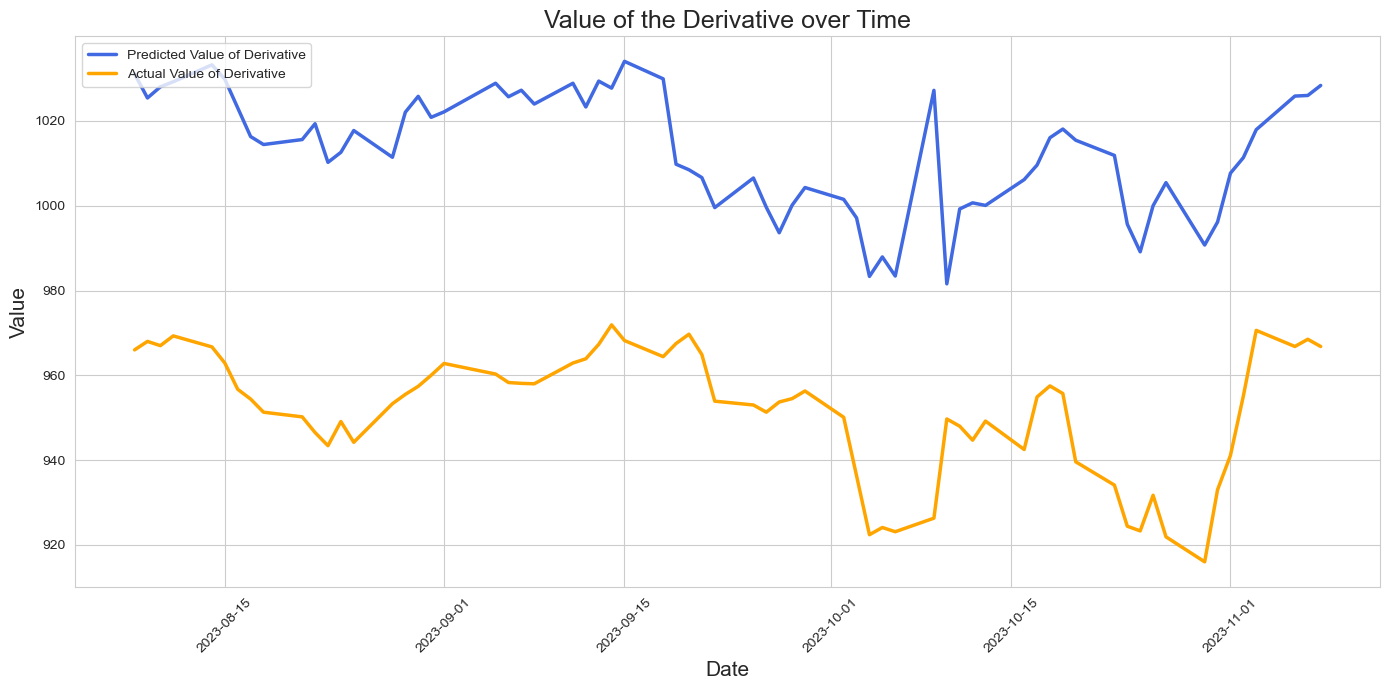

In [359]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for better styling

def plot_derivative(df):
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(df['Dates'], df['Terminal Prices'], color='royalblue', lw=2.5, label="Predicted Value of Derivative")
    plt.plot(df['Dates'], df['price']*10, color='orange', lw=2.5, label="Actual Value of Derivative")
    
    plt.title("Value of the Derivative over Time", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Value", fontsize=15)
    plt.legend(loc="upper left")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    
    plt.show()

plot_derivative(df.dropna())

In [22]:
df

,Date,variable,value
2820,2023-01-03,30 Yr,3.88
216,2023-01-03,1 Mo,4.17
2386,2023-01-03,10 Yr,3.79
433,2023-01-03,2 Mo,4.42
2169,2023-01-03,7 Yr,3.89
...,...,...,...
868,2023-11-10,6 Mo,5.46
2387,2023-11-10,20 Yr,4.93
2604,2023-11-10,30 Yr,4.73
2170,2023-11-10,10 Yr,4.61


# Test Antithetic

In [15]:
def SimMultiGBMexact_anti(n_sim, S0, v, Sigma, Deltat, T):
    m = int(T/Deltat)  # number of periods.
    p = len(S0)  # number of assets.
    print(f'Simulating for {len(S0)} assets, {m} trading days left to maturity')
    
    #cholesky decomposition for correlated multivariate normals
    L = np.linalg.cholesky(Sigma)
    
    #the shape is now (n_sim, p, m+1) to store n_sim paths for p assets over m+1 time points.
    S = np.zeros((n_sim, p, m+1))
    S[:, :, 0] = S0 
    
    mid = n_sim//2
    for i in range(mid):
        Z = np.dot(np.random.randn(m, p), L.T)#generate correlated random variables
        Z_anti = -Z
        for j in range(1, m+1):
            drift = (v - 0.5 * np.diag(Sigma)) * Deltat
            diffusion1 = np.sqrt(Deltat) * Z[j-1, :]
            diffusion2 = np.sqrt(Deltat) * Z_anti[j-1, :]
            S[i, :, j] = S[i, :, j-1] * np.exp(drift + diffusion1)
            S[i+mid, :, j] = S[i+mid, :, j-1] * np.exp(drift + diffusion2)
    return S

def get_derivative_prices_anti(df, start_date, end_date, product_end_date,sliding_window: int = 252):
    df.index = df.index.tz_localize(None)
    simulation_dates = df[(df.index >= start_date) & (df.index <= end_date)].index.tolist()
    derivative_prices = np.full(len(simulation_dates), np.nan)
    dt = 1/252
    for idx, date in enumerate(simulation_dates):
        historical_data = df[df.index < date].tail(sliding_window)
        trading_days = len(get_trading_days(date,product_end_date))        
        T = trading_days * dt #time to maturity
        underlying_prices = historical_data.iloc[:, 0:2].values
        log_prices = np.log(underlying_prices)
        log_returns = np.diff(log_prices, axis=0)
        v = np.mean(log_returns,axis=0)/dt
        sigma = np.cov(log_returns,rowvar=False)/dt #volatility here
        S0 = underlying_prices[0, :]
        simulated_prices = SimMultiGBMexact_anti(1000,S0, v, sigma, dt, T)
        payoffs = compute_payoff(simulated_prices, initial_levels, barrier, T, conversion_rates) # Added conversion rate
        derivative_prices[idx] = np.mean(payoffs)#monte carlo, can add other techniques here
        
    derivative_prices_df = pd.DataFrame({
        'Dates': simulation_dates,
        'Terminal Prices': derivative_prices
    })

    return derivative_prices_df

anti_df = get_derivative_prices_anti(underlying_assets,'2023-07-01','2023-10-01','2024-06-10')

Simulating for 2 assets, 243 trading days left to maturity
Simulating for 2 assets, 242 trading days left to maturity
Simulating for 2 assets, 241 trading days left to maturity
Simulating for 2 assets, 240 trading days left to maturity
Simulating for 2 assets, 239 trading days left to maturity
Simulating for 2 assets, 238 trading days left to maturity
Simulating for 2 assets, 237 trading days left to maturity
Simulating for 2 assets, 236 trading days left to maturity
Simulating for 2 assets, 235 trading days left to maturity
Simulating for 2 assets, 234 trading days left to maturity
Simulating for 2 assets, 233 trading days left to maturity
Simulating for 2 assets, 232 trading days left to maturity
Simulating for 2 assets, 231 trading days left to maturity
Simulating for 2 assets, 230 trading days left to maturity
Simulating for 2 assets, 229 trading days left to maturity
Simulating for 2 assets, 228 trading days left to maturity
Simulating for 2 assets, 227 trading days left to maturi

In [69]:
plot_derivative(anti_df)

NameError: name 'anti_df' is not defined

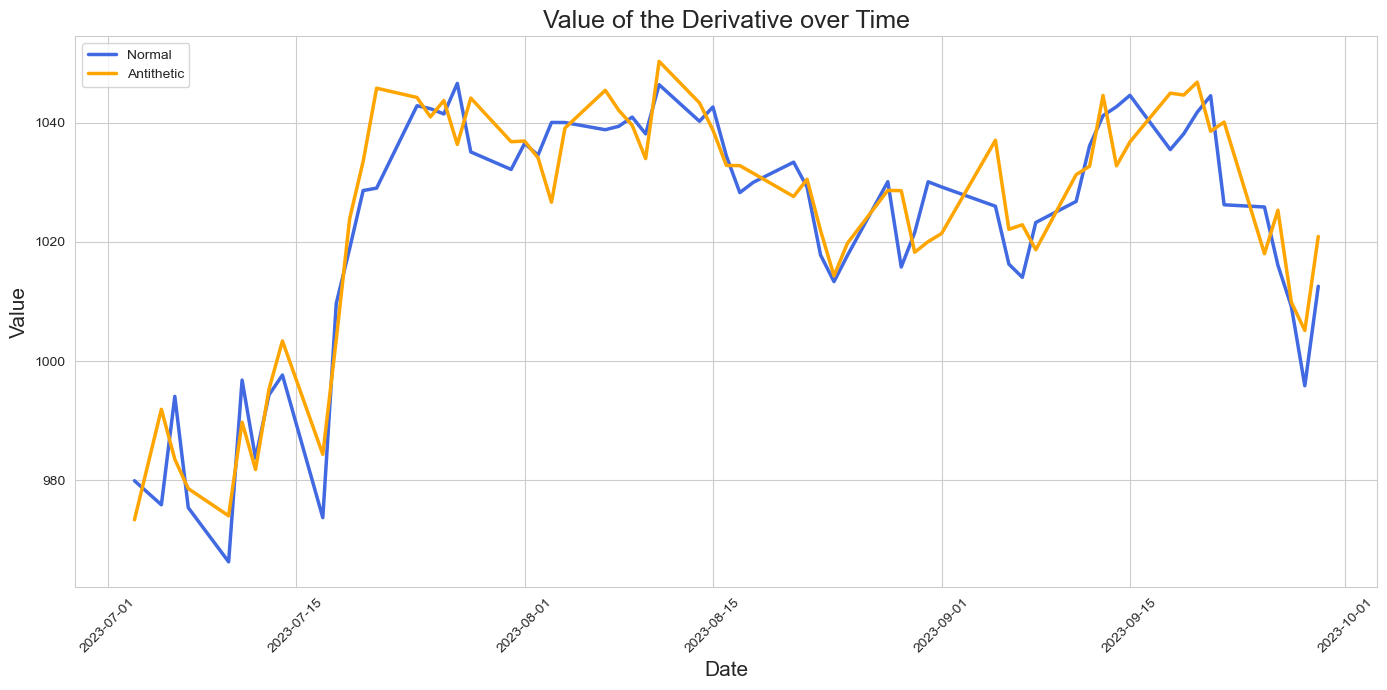

In [17]:
sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))
plt.plot(df['Dates'], df['Terminal Prices'], color='royalblue', lw=2.5, label="Normal")
plt.plot(anti_df['Dates'], anti_df['Terminal Prices'], color='orange', lw=2.5, label="Antithetic")

plt.title("Value of the Derivative over Time", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Value", fontsize=15)
plt.legend(loc="upper left")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

# Mgarch test

In [110]:
def get_derivative_prices_mgarch(df, start_date, end_date, product_end_date,sliding_window: int = 252):
    df.index = df.index.tz_localize(None)
    simulation_dates = df[(df.index >= start_date) & (df.index <= end_date)].index.tolist()
    derivative_prices = np.full(len(simulation_dates), np.nan)
    dt = 1/252
    for idx, date in enumerate(simulation_dates):
        historical_data = df[df.index < date].tail(sliding_window)
        trading_days = len(get_trading_days(date,product_end_date))        
        T = trading_days * dt #time to maturity
        underlying_prices = historical_data.iloc[:, 0:2].values
        log_prices = np.log(underlying_prices)
        log_returns = np.diff(log_prices, axis=0)
        v = np.mean(log_returns,axis=0)/dt
        #sigma = np.cov(log_returns,rowvar=False)/dt #volatility here
        
        vol = mgarch.mgarch()
        vol.fit(log_returns)
        sigma_nextday = vol.predict(sliding_window+1)['cov']
        print(sigma_nextday)
        S0 = underlying_prices[0, :]
        simulated_prices = SimMultiGBMexact(1000,S0, v, sigma_nextday, dt, T)
        payoffs = compute_payoff(simulated_prices, initial_levels, barrier, T, conversion_rates) # Added conversion rate
        derivative_prices[idx] = np.mean(payoffs)#monte carlo, can add other techniques here
        
    derivative_prices_df = pd.DataFrame({
        'Dates': simulation_dates,
        'Terminal Prices': derivative_prices
    })

    return derivative_prices_df

mgarch_df = get_derivative_prices(underlying_assets,'2023-07-01','2023-10-01','2024-06-10')

0.054299999999999994 [13.64026556 13.64863626] [[0.08666888 0.06582585]
 [0.06582585 0.06992749]]
Simulating for 2 assets, 243 trading days left to maturity
0.054000000000000006 [13.56460311 13.57307988] [[0.08679379 0.06578697]
 [0.06578697 0.06984025]]
Simulating for 2 assets, 242 trading days left to maturity


KeyboardInterrupt: 

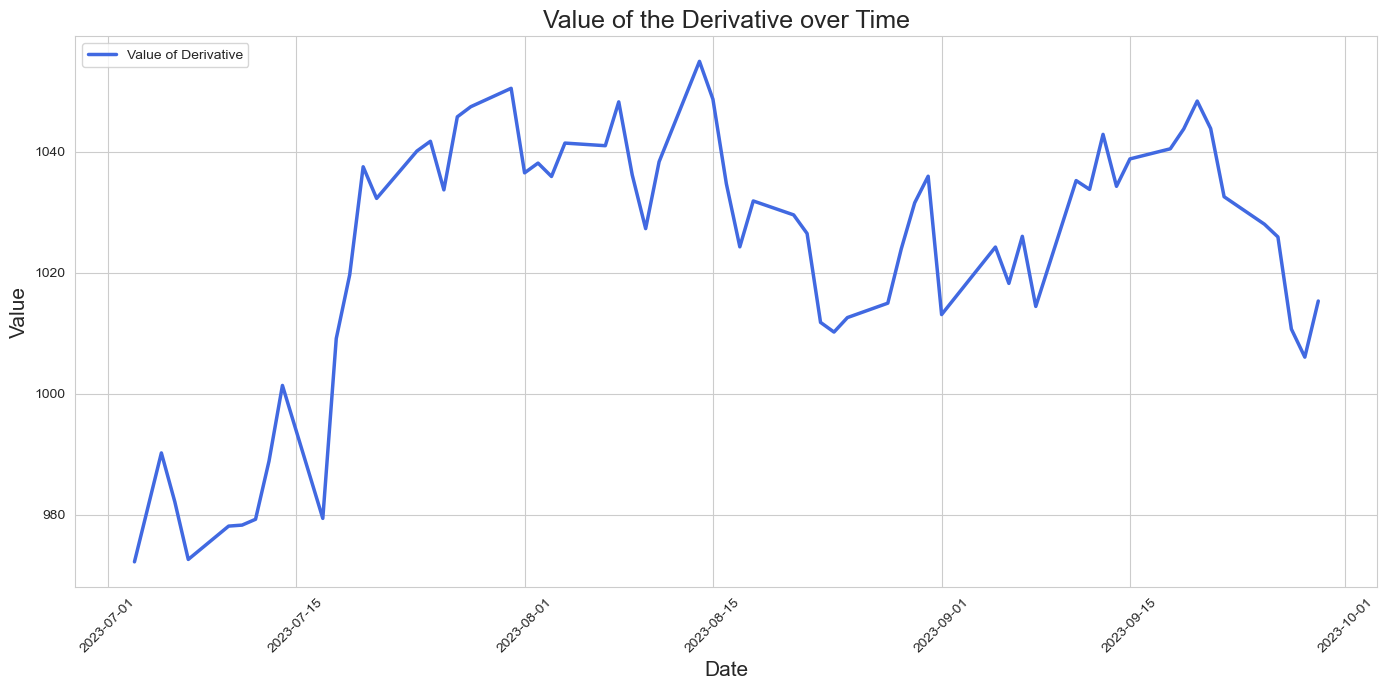

In [25]:
plot_derivative(mgarch_df)

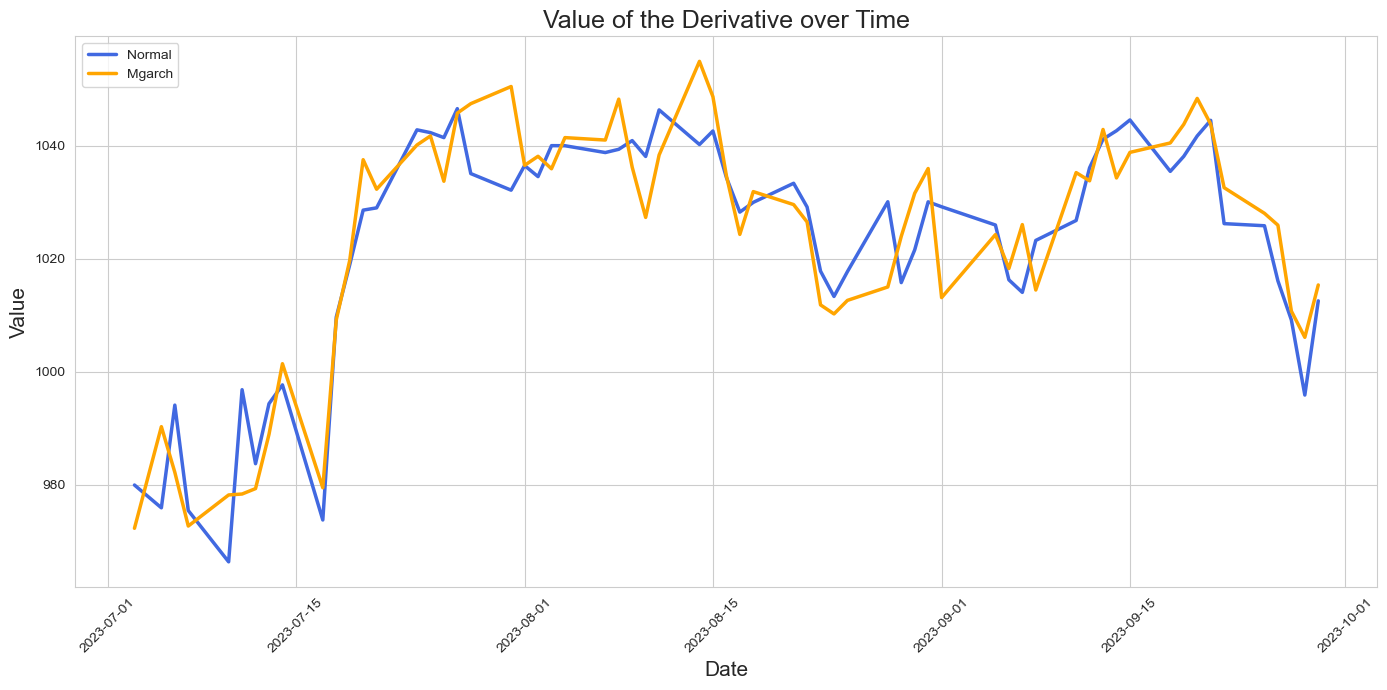

In [26]:
sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))
plt.plot(df['Dates'], df['Terminal Prices'], color='royalblue', lw=2.5, label="Normal")
plt.plot(mgarch_df['Dates'], mgarch_df['Terminal Prices'], color='orange', lw=2.5, label="Mgarch")

plt.title("Value of the Derivative over Time", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Value", fontsize=15)
plt.legend(loc="upper left")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

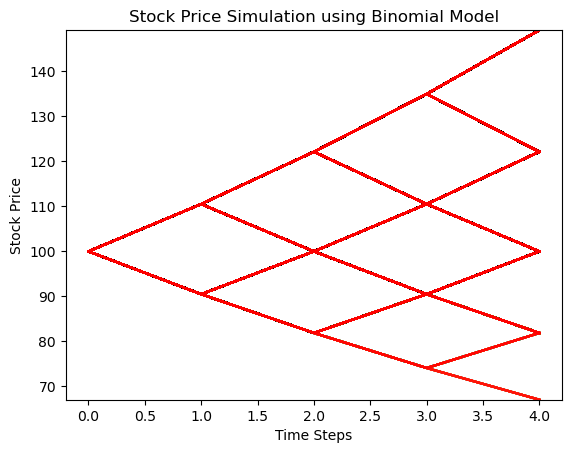

In [31]:
import numpy as np
import matplotlib.pyplot as plt

## BINOMIAL TREE

def binom_tree_fit(v, sigma, delta_t , approx=True):
    #parameters estimated with methods of moments 
    
    if approx: #approximated formula -> use when ?
        p = 0.5 + v * np.sqrt(delta_t) / sigma / 2
        u = np.exp(sigma * np.sqrt(delta_t))
        d = 1 / u
    else: #exact formula
        p = 0.5 + v * delta_t / (2 * np.sqrt((v * delta_t)**2 + sigma**2 * delta_t))
        u = np.exp(np.sqrt((v * delta_t)**2 + sigma**2 * delta_t))
        d = 1 / u
    return {'p': p, 'u': u, 'd': d}

def sim_binom_tree(n:int, starting_price:float, u:float, d:float, p:float, delta_t:float, T:int=1)->np.ndarray:
    m = int(T/delta_t)
    S = np.zeros((n, m+1))
    S[:, 0] = starting_price
    for i in range(n):
        Z = np.random.binomial(1, p, m) * (u - d) + d
        S[i, 1:] = starting_price * np.cumprod(Z)
    return S

def visualize(S,title:str):
    n = S.shape[0]
    colors = plt.cm.rainbow(np.linspace(0, 1, n))
    for i in range(n):
        plt.plot(S[i, :], color=colors[i])
    plt.ylim(S.min(), S.max())
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.title(title)
    plt.show()


S0 = 100
T = 1
delta_t = 0.25
result = binom_tree_fit(0.2, 0.2, delta_t, approx=True)
u = result['u']
d = result['d']
p = result['p']


paths = sim_binom_tree(10000, S0, u, d, p, delta_t, T)
visualize(paths,"Stock Price Simulation using Binomial Model")

In [122]:
import math

# boa_prices = np.array(boa["Close"])
# def sim_GBM_sde(n_sim, S0, mu, sigma, delta_t, T):
#     """
#     Simulate stock prices using the Geometric Brownian Motion (GBM) model via Euler scheme.
#     """
#     m = int(T/delta_t)
#     S = np.zeros((n_sim, m+1))
#     S[:, 0] = S0
#     for i in range(n_sim):
#         Z = np.random.normal(0, 1, m)
#         for j in range(1, m+1):
#             S[i, j] = S[i, j-1] + S[i, j-1] * (mu * delta_t + sigma * np.sqrt(delta_t) * Z[j-1])
#     return S

def sim_GBM_exact(n_sim, S0, mu, sigma, delta_t,T,risk_neutral=True,r=0.02):
    """
    Simulate stock prices using the Geometric Brownian Motion (GBM) model with exact discretization.
    """
    v = mu - sigma**2/2 if not risk_neutral else r - sigma**2/2
    m = int(T/delta_t)
    S = np.zeros((n_sim, m+1))
    S[:, 0] = S0
    for i in range(n_sim):
        Z = np.random.normal(0, 1, m)
        for j in range(1, m+1):
            S[i, j] = S[i, j-1] * np.exp(v * delta_t + sigma * np.sqrt(delta_t) * Z[j-1])
    return S


# # Parameters
# S0 = boa_prices[-252]
# print(S0)
# boa_prices = np.log(boa_prices)
# boa_prices = np.diff(boa_prices)
# print(np.size(boa_prices))
# delta_t = 1/252
# mu = np.mean(boa_prices[:59])/delta_t
# sigma = np.std(boa_prices[:59])/ np.sqrt(delta_t)
# T = 1

def get_terminal_prices(df, start_date, end_date, sliding_window: int = 252):
    dates = pd.date_range(start=start_date, end=end_date, tz=df.index.tz)
    terminal_prices = np.full(len(dates), np.nan)
    delta_t = 1
    T = 1
    for idx, date in enumerate(dates):
        # Extract sliding window data before the current date
        historical_data = df[df.index < date].tail(sliding_window)
        if len(historical_data) < sliding_window:
            terminal_prices.append(np.nan)  # Not enough data for this date
            continue
        log_returns = np.diff(np.log(historical_data.values.squeeze()))
        mu = np.mean(log_returns)/dt
        sigma = np.std(log_returns)/np.sqrt(dt)
        S0 = historical_data.values[-1].squeeze()
        paths = sim_GBM_exact(1000, S0, mu, sigma, delta_t, T)
        price = np.mean(paths[:,-1])  # Mean of terminal prices
        terminal_prices[idx] = np.mean(paths[:, -1])  # Store the mean of terminal prices directly in the array
    
    return terminal_prices


# print(get_terminal_prices(boa['Close'], "2023-07-01", "2023-10-01"))

In [18]:
import numpy as np
import pandas as pd
from scipy.linalg import cholesky
from pandas.tseries.holiday import USFederalHolidayCalendar

def SimMultiGBMexact(n_sim, S0, v, Sigma, Deltat, T):
    m = int(T/Deltat)  #number of periods.
    p = len(S0)  #number of assets.
    print(f'Simulating for {len(S0)} assets, {m} trading days left to maturity')
    
    #the shape is now (n_sim, p, m+1) to store n_sim paths for p assets over m+1 time points.
    S = np.zeros((n_sim, p, m+1))
    S[:, :, 0] = S0 
    
    #simulate multi GBM paths for n_sim paths.
    for i in range(n_sim):
        Z = np.random.multivariate_normal(v * Deltat, Sigma * Deltat, m)
        for j in range(1, m+1):
            S[i, :, j] = np.exp(np.log(S[i, :, j-1]) + Z[j-1, :])
    
    return S

def compute_payoff(simulated_prices, initial_levels, barrier, T, denomination=100.0):
    n_sim, p, _ = simulated_prices.shape
    
    if T > 1:
        current_quarter = 1
    elif 0.75 < T <= 1:
        current_quarter = 2
    elif 0.5 < T <= 0.75:
        current_quarter = 3
    elif 0.25 < T <= 0.5:
        current_quarter = 4
    else:  # T <= 0.25
        current_quarter = 5
    #coupon map
    coupons = {
        1: 0.0,
        2: 0.05125,
        3: 0.076875,
        4: 0.1025,
        5: 0.128125 
    }

    payoffs = np.full((n_sim, p), denomination + 0.128125 * denomination)

    if current_quarter in [2, 3, 4, 5] and np.all(simulated_prices[:, :, current_quarter - 1] >= initial_levels, axis=1).all():
        payoffs = denomination + coupons[current_quarter] * denomination

    elif np.any(simulated_prices[:, :, :current_quarter] < barrier[np.newaxis, :, np.newaxis], axis=2).any(axis=1).any():
        worst_performance = simulated_prices[:, :, current_quarter - 1].min(axis=1)
        payoffs = worst_performance[:, np.newaxis] + 0.128125 * denomination

    return payoffs

initial_levels = np.array([35, 123])
barrier = initial_levels *0.55
print(barrier)

def get_trading_days(start_date, product_end_date):
    all_dates = pd.date_range(start=start_date, end=product_end_date)
    week_days = all_dates[all_dates.weekday < 5]
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=start_date, end=end_date)
    trading_days = week_days[~week_days.isin(holidays)]
    return trading_days

[19.25 67.65]


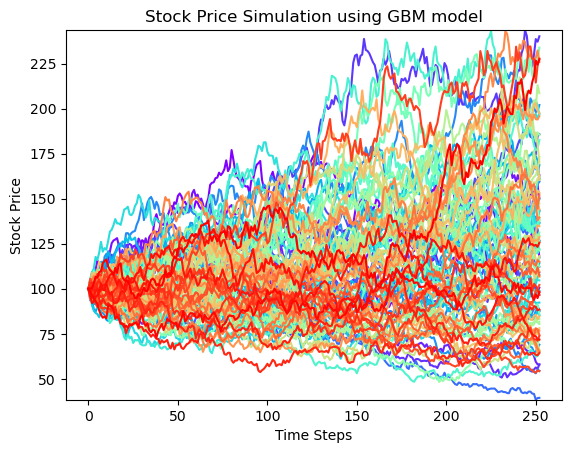

In [134]:
paths = sim_GBM_sde(100, S0, mu, sigma, delta_t, T)
visualize(paths,"Stock Price Simulation using GBM model")



# The Wiener process, \( W_t \), has the following properties:

# 1. \( W_0 = 0 \) (starts at zero)
# 2. The increments are independent: \( W_t - W_s \) is independent of the history \(\{ W_u : u \leq s \} \) for any \( s < t \).
# 3. For any \( s < t \), the increment \( W_t - W_s \) is normally distributed with mean 0 and variance \( t-s \).
# 4. \( W_t \) has continuous paths.

# Given these properties, when we're working in discrete time with time steps of size \( \Delta t \), the increment \( \Delta W_t \) (which is approximately equal to \( W_{t+\Delta t} - W_t \)) is normally distributed with mean 0 and variance \( \Delta t \). This is why we can represent \( \Delta W_t \) as \( \sqrt{\Delta t} \times Z \), where \( Z \) is a standard normal variable.

# When we are simulating the GBM in discrete time, we're approximating the continuous-time process by taking steps of size \( \Delta t \). For each step, the change in the Wiener process, \( \Delta W_t \), is approximated as \( \sqrt{\Delta t} \times Z \) where \( Z \) is a realization of a standard normal random variable.

# So in essence, \( Z \) itself does not represent \( dW_t \), but when it's multiplied by \( \sqrt{\Delta t} \), it's giving us a discrete-time approximation to the increment of the Wiener process over the interval \( \Delta t \).

In [158]:
import numpy as np

def sim_GBM_exact_AV(Nsim, S0, v, sigma, Deltat, T, collate=False):
    m = int(T/Deltat)
    S = np.zeros((Nsim, m+1))
    Stilde = np.zeros((Nsim, m+1))
    S[:,0] = S0
    Stilde[:,0] = S0
    
    for i in range(Nsim):
        Z = np.random.randn(m)
        for j in range(1, m+1):
            S[i,j] = S[i,j-1] * np.exp(v*Deltat + sigma*np.sqrt(Deltat)*Z[j-1])
            Stilde[i,j] = Stilde[i,j-1] * np.exp(v*Deltat + sigma*np.sqrt(Deltat)*(-Z[j-1]))
    
    if collate:
        out = np.zeros((2*Nsim, m+1))
        for i in range(Nsim):
            out[2*i] = S[i]
            out[2*i+1] = Stilde[i]
        return out
    else:
        return np.vstack((S, Stilde))



Nsim = 100
S0 = 10
v = 0.05
sigma = 0.2
Deltat = 0.01
T = 1
paths = sim_GBM_exact_AV(Nsim, S0, v, sigma, Deltat, T , collate=False)

In [73]:
import numpy as np
import statistics
#we want to estimate theta = E(4x^3) with simulation techniques

#using monte carlo:
estimates = []
rounds = 1000
for i in range(rounds):
    n = 1000
    uni = np.random.uniform(low=0.0, high=1.0, size=2*n)
    mc = (0.5/n)*np.sum(4*uni**3)
    estimates.append(mc)

print(statistics.variance(estimates))
print(statistics.mean(estimates))

0.000618404826696849
0.9984007717209588


In [68]:
#using anti variate approach:
estimates = []
rounds = 1000
for i in range(rounds):
    n = 1000
    uni = np.random.uniform(low=0.0, high=1.0, size=n)
    neg_uni = 1 - uni

    uni = 4*uni**3
    neg_uni = 4*neg_uni**3
    av = (0.5/n)*np.sum(uni+neg_uni)
    estimates.append(av)

print(statistics.variance(estimates))
print(statistics.mean(estimates))


0.00018404219661642625


0.9996660954771995

In [152]:
#using control variate approach:
#let yi = uniform distribution, xi = 4u^^3
#regress x on y

def compute_covariance(x, y):
    if len(x) != len(y):
        raise ValueError("Input vectors must have the same length")
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    return np.sum((x - mean_x) * (y - mean_y)) / (len(x))

estimates = []
rounds = 10000
for i in range(rounds):
        n = 1000
        y = np.random.uniform(low=0.0, high=1.0, size=2*n)
        x = 4*np.random.uniform(low=0.0, high=1.0, size=2*n)**3
        
        # Fitting a linear regression: x = a + c*y
        A = np.vstack([y, np.ones(len(y))]).T
        c, a = np.linalg.lstsq(A, x, rcond=None)[0]
        
        # Using the estimated coefficient c for the control variate estimate
        cv = (0.5/n)*np.sum(x+(c*(y-(1/2))))
        estimates.append(cv)

print(statistics.variance(estimates))
print(statistics.mean(estimates))

0.0006524473949871813
1.000390500354925


In [151]:
#using stratified sampling approach:
estimates = []
rounds = 10000

#2 strata

for i in range(rounds):
    n = 1000
    u = np.random.uniform(low=0.0, high=1.0, size=n)
    u1 = u/3
    u2 = (u+1)/3
    u3 = (u+2)/3
    u1 = 4*u1**3
    u2 = 4*u2**3
    u3 = 4*u3**3

    
    sv = ((1/3)/n)*np.sum(u1+u2+u3)
    estimates.append(sv)

print(statistics.variance(estimates))
print(statistics.mean(estimates))

0.00014747101935031325
0.9999948961286447


In [202]:
import numpy as np
from scipy.stats import norm


def stratified_sampling(StratraNo, NsimS, S0, v, sigma, T):
    V = []
    for i in range(1,StratraNo):
        lower_bound = i/StratraNo
        upper_bound = (i+1)/StratraNo
        V.extend(np.random.uniform(low=lower_bound, high=upper_bound, size=NsimS))
    
    V = np.array(V)
    Z = norm.ppf(V)  # Convert uniform samples to normal using the quantile function
    ST = S0 * np.exp(v * T + sigma * np.sqrt(T) * Z)
    
    return ST

def monte_carlo(Nsim, S0, v, sigma, T):
    Z = np.random.normal(loc=0.0, scale=1.0, size=Nsim)
    ST = S0 * np.exp(v * T + sigma * np.sqrt(T) * Z) #closed form solution
    return ST

K = 1
Nsim = 2000


def fx(x:np.array)->np.array:
    function_values = 1 / (1 + np.exp(x - K))
    return function_values

    
    
simulated_x = stratified_sampling(20,Nsim, S0=1, v=0.05 - 0.2**2 / 2, sigma=0.2, T=1)

#monte carlo
simulated_x = monte_carlo(Nsim, S0=1, v=0.05 - 0.2**2 / 2, sigma=0.2, T=1)

#Estimate expected value
estimate = np.mean(fx(simulated_x))
variance = np.var(fx(simulated_x))
print(estimate)
print(variance)


0.48704269000559175
0.0026592062401958943


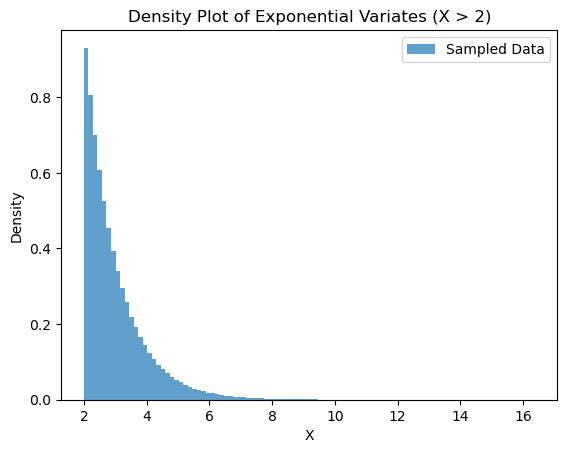

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def generate_exp_gt_2():
    U = np.random.uniform(0,1)
    Y = -np.log(1-U) + 2
    return Y



samples = [generate_exp_gt_2() for _ in range(1000000)]

plt.hist(samples, bins=100, density=True, alpha=0.7, label="Sampled Data")
plt.xlabel("X")
plt.ylabel("Density")
plt.title("Density Plot of Exponential Variates (X > 2)")
plt.legend()
plt.show()

In [19]:
np.mean(samples)

2.9998482443085583

In [351]:
#assignment question 2



1.005314668151069
1.0021856716935549


In [8]:
simulations = 1000
import math

def f(paths:np.array)->np.array:
    return (paths-2)*math.exp(-2)

def generate_mc()->np.array:
    U1 = np.random.uniform(0,1,size=simulations)
    Y1 = 2-np.log(1-U1)    
    return f(Y1)


paths = generate_mc()
print(np.mean(paths))
print(np.var(paths))

0.13000449442213785
0.015676847567109624


In [10]:
simulations = 1000

def f(paths:np.array)->np.array:
    return (paths-2)*math.exp(-2)

def generate_av()->np.array:
    U1 = np.random.uniform(0,1,size=simulations//2)
    U2 = 1-U1
    Y1 = 2-np.log(1-U1)
    Y2 = 2-np.log(1-U2)
    
    return f(Y1)+f(Y2)

paths = generate_av()
print(np.mean(paths)/2)
print(np.var(paths))

0.13810313227613602
0.016117506525109394


In [16]:
simulations = 1000

def f(paths:np.array)->np.array:
    return (paths-2)*math.exp(-2)

def generate_ss()->float:
    stratas = []
    for i in range(5):
        U = np.random.uniform(0,1,size=simulations//5)
        V = ((i-1)/5) + U
        Y = 2-np.log(1-U)
        stratas.append(np.sum(f(Y)))
    
    print(stratas)
    return sum(stratas)/simulations
    
generate_ss()

[28.99546955995504, 26.47092267136525, 29.34568164006593, 28.85019645130963, 23.68570450294346]


0.13734797482563932

In [93]:
simulations = 10000
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

def f(paths:np.array)->np.array:
    return (paths)*math.exp(-2)

def generate_cv()->np.array:
    U = np.random.uniform(0,1,size=simulations)
    Y = 2-np.log(1-U)
    X = Y-2
    lr.fit(y=X,X=Y.reshape(-1, 1))
    c= -lr.coef_[0]
    print(c)
    
    return f(X)+(c*(Y-3))

paths = generate_cv()
print(np.mean(paths))
print(np.var(paths))

-0.9999999999999667
0.1353392048855533
0.7479101041517763


In [374]:
from scipy.stats import expon

vals = expon.rvs(scale=1, size=100000)
vals_less = vals[vals>=2]-2
print(sum(vals_less)/len(vals))

0.13269071701882817


In [375]:
vals = expon.rvs(scale=1, size=100000)
vals_less = vals[vals>=2]-2
print(sum(vals_less)/len(vals_less))

1.003209020469779
